In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import pickle
import gzip
%matplotlib inline

# Reading dataset

In [2]:
with gzip.open('../cache/dataset_fixed.pkl.gz', 'rb') as f:
    X, y = pickle.load(f)

In [3]:
len(X), len(y)

(18117, 18117)

In [4]:
a = [x for x, y_ in zip(X, y) if y_ == 0]
c = [x for x, y_ in zip(X, y) if y_ == 2]

In [6]:
len(a), len(c)

(1647, 16470)

In [7]:
from IPython.display import Audio, display

In [9]:
wids = [Audio(a[i], rate=22050) for i in np.random.randint(0, len(a), 3)]

In [10]:
for w in wids:
    display(w)

In [11]:
wids = [Audio(c[i], rate=22050) for i in np.random.randint(0, len(c), 3)]

In [12]:
for w in wids:
    display(w)

# Plots

In [13]:
def plot_waves(sound_names, raw_sounds):
    i = 1
    l = len(raw_sounds)
    
    for n, f in zip(sound_names, raw_sounds):
        fig = plt.figure(figsize=(8, 5))
        librosa.display.waveplot(np.array(f), sr=22050)
        plt.title(n.title())
        i += 1
    plt.show()
    

def plot_specgram(sound_names, raw_sounds):
    i = 1
    l = len(raw_sounds)
    
    for n, f in zip(sound_names, raw_sounds):
        fig = plt.figure(figsize=(8, 5))
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.show()

    
def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    l = len(raw_sounds)
    
    for n, f in zip(sound_names, raw_sounds):
        fig = plt.figure(figsize=(8, 5))
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D, x_axis='time', y_axis='log')
        plt.title(n.title())
        i += 1
    plt.show()

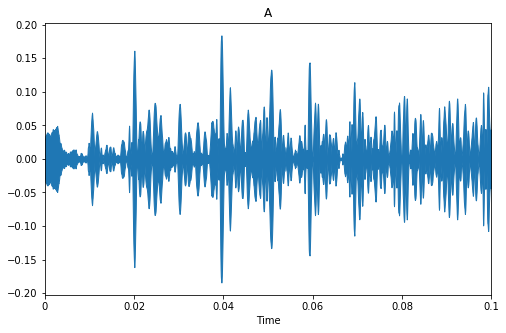

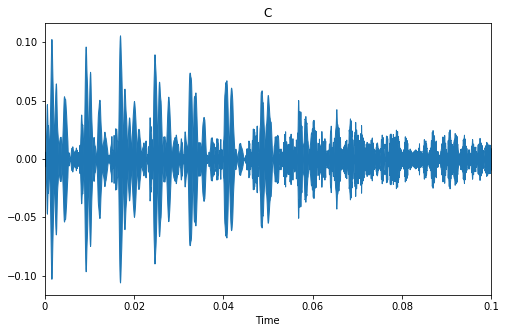

In [14]:
plot_waves(['a', 'c'], [a[0], c[0]])

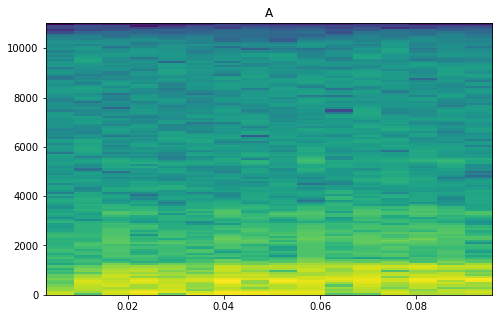

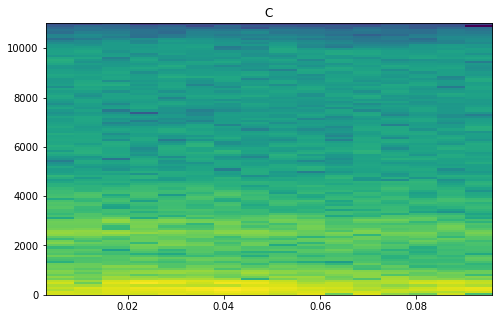

In [15]:
plot_specgram(['a', 'c'], [a[0], c[1]])

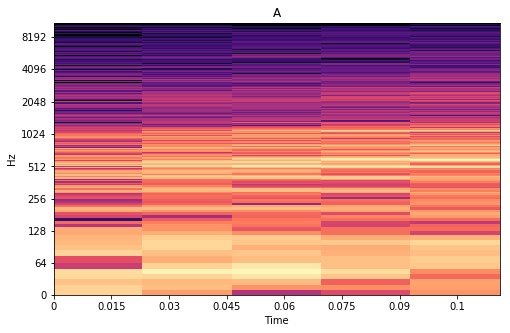

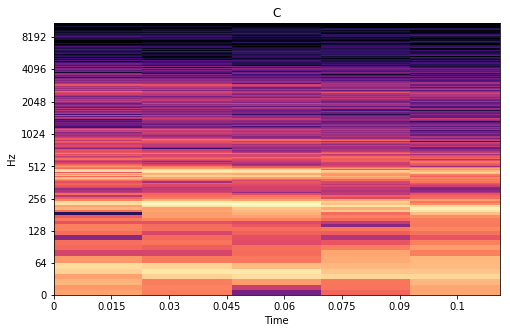

In [16]:
plot_log_power_specgram(['a', 'c'], [a[0], c[1]])

# Mel images

In [18]:
plot_log_power_specgram??

In [44]:
D = librosa.logamplitude(np.abs(librosa.stft(a[0], n_fft=200))**2, ref_power=np.max)

In [45]:
D.shape

(101, 45)

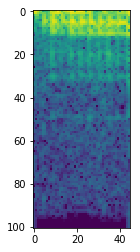

In [46]:
plt.imshow(D)

In [47]:
librosa.feature.melspectrogram??

In [65]:
D = librosa.feature.melspectrogram(a[0], hop_length=10, n_fft=1000)

In [66]:
D.shape

(128, 221)

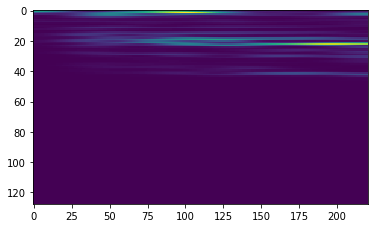

In [67]:
plt.imshow(D)

In [69]:
D.shape

(128, 221)

In [72]:
np.expand_dims(D, axis=-1).shape

(128, 221, 1)

In [73]:
def extract_feature(x, sample_rate=22050, n_fft=200):
    D = librosa.logamplitude(np.abs(librosa.stft(x, n_fft=n_fft))**2, ref_power=np.max)
    return np.expand_dims(D, axis=-1)

In [76]:
D = extract_feature(a[0])

In [80]:
%time _ = extract_feature(a[0])

CPU times: user 49 ms, sys: 648 µs, total: 49.6 ms
Wall time: 48.6 ms


In [81]:
X_features = np.stack([extract_feature(x) for x in X])

In [82]:
X_features.shape

(18117, 101, 45, 1)

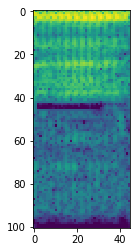

In [88]:
plt.imshow(X_features[3, :, :, 0])

# Cnn model

In [161]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [192]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [133]:
y = [i if i == 0 else 1 for i in y]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)

---

In [237]:
model = Sequential()
model.add(Conv2D(16, 5, input_shape=X_features.shape[1:], activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 5, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy')

In [238]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 97, 41, 16)        416       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 48, 20, 16)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 44, 16, 16)        6416      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 22, 8, 16)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 20, 6, 16)         2320      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 10, 3, 16)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 480)               0         
__________

## Predict without training

In [223]:
pr = model.predict_classes(X_test, batch_size=128, verbose=1)

3624/3624 [==============================] - 8s 2ms/step


In [224]:
pr = pr.ravel()

In [225]:
pd.Series.value_counts(pr)

0    3624
dtype: int64

In [226]:
accuracy_score(y_test, pr)

0.090783664459161154

In [227]:
print(classification_report(y_test, pr))

             precision    recall  f1-score   support

          0       0.09      1.00      0.17       329
          1       0.00      0.00      0.00      3295

avg / total       0.01      0.09      0.02      3624



/home/evgeny/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Training

In [239]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=5,
                 class_weight={0: 5, 1: 1},
                 validation_data=(X_test, y_test))

Train on 14493 samples, validate on 3624 samples
Epoch 1/5
14493/14493 [==============================] - 80s 6ms/step - loss: 0.9614 - val_loss: 0.3948
Epoch 2/5
14493/14493 [==============================] - 79s 5ms/step - loss: 0.4754 - val_loss: 0.1739
Epoch 3/5
14493/14493 [==============================] - 79s 5ms/step - loss: 0.4446 - val_loss: 0.1675
Epoch 4/5
14493/14493 [==============================] - 78s 5ms/step - loss: 0.4227 - val_loss: 0.1997
Epoch 5/5
14493/14493 [==============================] - 78s 5ms/step - loss: 0.4052 - val_loss: 0.2417


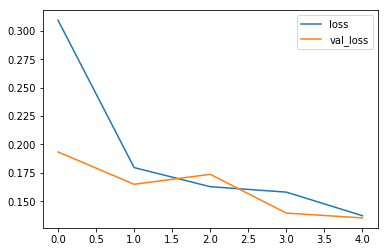

In [181]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

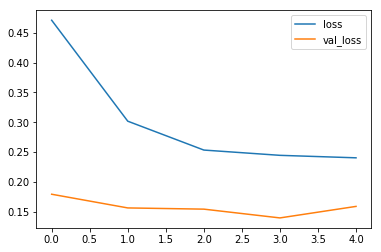

In [229]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

In [241]:
pr = model.predict_classes(X_test, batch_size=64, verbose=1)

3624/3624 [==============================] - 7s 2ms/step


In [242]:
pr = pr.ravel()

In [243]:
pd.Series.value_counts(pr)

1    3089
0     535
dtype: int64

In [244]:
accuracy_score(y_test, pr)

0.91611479028697573

In [245]:
cm = confusion_matrix(y_test, pr)

In [246]:
cm

array([[ 280,   49],
       [ 255, 3040]])

In [159]:
print(classification_report(y_test, pr))

             precision    recall  f1-score   support

          0       0.85      0.72      0.78       351
          2       0.97      0.99      0.98      3273

avg / total       0.96      0.96      0.96      3624



In [208]:
print(classification_report(y_test, pr))

             precision    recall  f1-score   support

          0       0.78      0.70      0.74       329
          1       0.97      0.98      0.98      3295

avg / total       0.95      0.95      0.95      3624



In [236]:
print(classification_report(y_test, pr))

             precision    recall  f1-score   support

          0       0.62      0.80      0.70       329
          1       0.98      0.95      0.97      3295

avg / total       0.95      0.94      0.94      3624



In [247]:
print(classification_report(y_test, pr))

             precision    recall  f1-score   support

          0       0.52      0.85      0.65       329
          1       0.98      0.92      0.95      3295

avg / total       0.94      0.92      0.92      3624



In [248]:
%time model.predict(X_test[:1, :, :, :])

CPU times: user 9.45 ms, sys: 310 µs, total: 9.76 ms
Wall time: 5.9 ms


array([[ 0.89805168]], dtype=float32)

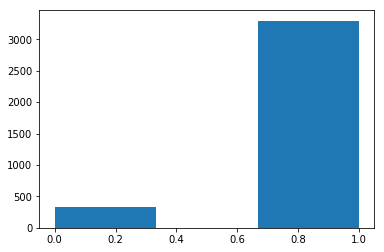

In [249]:
plt.hist(y_test, bins=3);

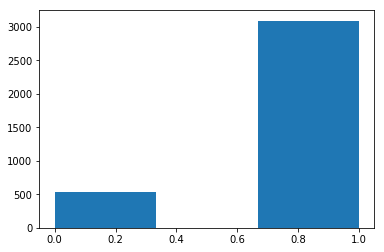

In [250]:
plt.hist(pr, bins=3);

In [176]:
accuracy_score(y_test, [1] * len(y_test))

0.9092163355408388

In [251]:
model.get_weights()[0].shape

(5, 5, 1, 16)

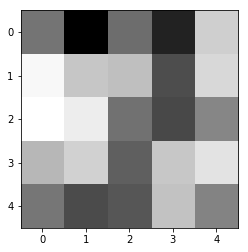

In [252]:
plt.imshow(model.get_weights()[0][:, :, 0, 4])
plt.gray()

# Testing on new data

In [253]:
def get_praat_annotations(paths):
    dfs = []
    for path in paths:
        with open(path) as f:
            annotation = [l.strip() for l in f.readlines()]
            
        indxs = [i for i, l in enumerate(annotation) if l == '"IntervalTier"']
        annotation = annotation[indxs[0] + 5:indxs[1] if len(indxs) > 1\
                                else len(annotation)]
        annotation_dicts = []

        for s, e, l in zip(annotation[0::3], annotation[1::3], annotation[2::3]):
            annotation_dicts.append({
                'start': float(s),
                'finish': float(e),
                'label': l.replace('"', ''),
                'length': float(e) - float(s)
            })
        df = pd.DataFrame(annotation_dicts)
        dfs.append(df)
    return dfs

test_annotation = get_praat_annotations(['../annotations/arhis1.TextGrid'])

In [254]:
test_audio, sr = librosa.load('../audio/arhis1.m4a')

In [255]:
interval_time = 0.1
interval_step = 0.05

interval_len, step_len = librosa.time_to_samples(interval_time)[0],\
                 librosa.time_to_samples(interval_step)[0]

In [257]:
interval_len, step_len

(2205, 1102)

In [258]:
def get_label_data(annotation, audio, labels, sr=22050):
    # по дефолту все 2го класса
    data = pd.Series(index=np.arange(0, len(audio) - interval_len, step_len), data=2)
    label_map = {'a': 0, 'b': 1, 'c': 2}
    for label in labels:
        l = label_map[label]
        start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
        finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
        for s, f in zip(start_samples_indxs, finish_samples_indxs):
            s = int(np.round(s / step_len)) * step_len
            f = (int(np.round(f / step_len)) - 2) * step_len
            # вычитаем 2 потому что f - это конец интервала, в Series мы заносим метку для 
            # начала  интервала, длина интервала 2 * step, поэтому нужно вычесть 2
            data[(data.index >= s) & (data.index <= f)] = l
    return data

In [259]:
test_data = get_label_data(test_annotation[0], test_audio, ['a', 'b'])

In [260]:
test_data.shape

(6346,)

In [261]:
test_data.value_counts()

2    6002
0     344
dtype: int64

In [271]:
test_data = test_data.replace({2: 1})

In [272]:
test_data.value_counts(True)

1    0.945793
0    0.054207
dtype: float64

In [263]:
test_samples = [test_audio[i:i + interval_len] for i in test_data.index]

In [264]:
test_samples[0].shape

(2205,)

In [265]:
len(test_samples)

6346

In [266]:
test_features = np.stack([extract_feature(x) for x in test_samples])

In [267]:
test_predict = model.predict_classes(test_features, batch_size=128)

In [268]:
test_predict_pr = model.predict_proba(test_features, batch_size=128)

In [94]:
# accuracy_score(test_data.values, test_predict) с 3мя классами 

0.93838638512448791

In [188]:
accuracy_score(test_data.values, test_predict) # c 2мя

0.94957453514024581

In [273]:
accuracy_score(test_data.values, test_predict) # c 2мя cnn

0.94705326189725814

In [95]:
accuracy_score(test_data.values, [2] * len(test_predict))

0.94579262527576424

In [97]:
# print(classification_report(test_data.values, test_predict)) # 3 класса

             precision    recall  f1-score   support

          0       0.60      0.30      0.40       344
          1       0.00      0.00      0.00         0
          2       0.96      0.98      0.97      6002

avg / total       0.94      0.94      0.94      6346



/home/evgeny/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [189]:
# print(classification_report(test_data.values, test_predict))

             precision    recall  f1-score   support

          0       0.85      0.08      0.15       344
          2       0.95      1.00      0.97      6002

avg / total       0.94      0.95      0.93      6346



In [274]:
print(classification_report(test_data.values, test_predict)) # cnn

             precision    recall  f1-score   support

          0       0.52      0.40      0.45       344
          1       0.97      0.98      0.97      6002

avg / total       0.94      0.95      0.94      6346



In [ ]:
# test_predict_new = 1 * (test_predict_pr[:, 1] > 0.95).astype(int)

In [285]:
test_predict_new = 1 * (test_predict_pr > 0.7).astype(int)

In [286]:
print(classification_report(test_data.values, test_predict_new))

             precision    recall  f1-score   support

          0       0.44      0.49      0.46       344
          1       0.97      0.96      0.97      6002

avg / total       0.94      0.94      0.94      6346



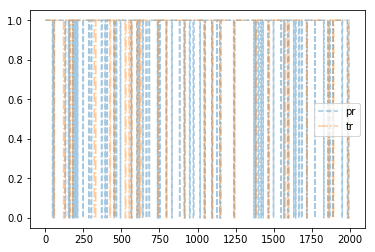

In [287]:
plt.plot(test_predict_new[:2000], '--', label='pr', alpha=0.4)
plt.plot(test_data.iloc[:2000].values, '-.', label='tr', alpha=0.4)
plt.legend()

## Отображение результата

In [288]:
from PIL import Image
import os
import shutil

In [289]:
# os.rmdir('../cache/imgs/')
shutil.rmtree('../cache/imgs/')

In [290]:
os.mkdir('../cache/imgs')

In [291]:
for i, (r, t) in enumerate(zip(test_predict_new, test_data.values)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 1:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 1:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [292]:
os.system('ffmpeg -r 20 -i ../cache/imgs/test_%04d.png -i ../audio/arhis1.mp3 -vcodec mpeg4 -y ../cache/a.mp4')

0

## Ручная корректировка шума

In [294]:
test_predict_new = test_predict_new.ravel()

In [311]:
test_predict_new2 = []

start = False
for t, tn in zip(test_predict_new, np.append(test_predict_new[1:], [1])):
    if t == 0 and tn == 0 and not start:
        # если встретили 0 и следующий 0 и до этого не началось, включаем начало и доб-ем 0
        start = True
        test_predict_new2.append(0)
    elif t == 0 and tn == 0 and start:
        # если встретили 0 и следующий 0 и до этого началось, доб-ем 0 - мы в серии нулей
        test_predict_new2.append(0)
    elif t == 0 and tn != 0 and not start:
        # если встретили 0, а следующий не 0 и до этого не началось, значит шум, не 0 
        test_predict_new2.append(1)
    elif t == 0 and tn != 0 and start:
        # если встретили 0, а след. не 0 и до этого началось, значит 0, но начало в False
        start = False
        test_predict_new2.append(0)
    elif t == 1:
        # если встрили 1, добавляем 1
        test_predict_new2.append(1)
        start = False
    else:
        print(t, tn, start)

In [315]:
pd.Series.value_counts(test_predict_new)

1    5962
0     384
dtype: int64

In [316]:
pd.Series.value_counts(test_predict_new2)

1    6024
0     322
dtype: int64

In [317]:
print(classification_report(test_data.values, test_predict_new))

             precision    recall  f1-score   support

          0       0.44      0.49      0.46       344
          1       0.97      0.96      0.97      6002

avg / total       0.94      0.94      0.94      6346



In [318]:
print(classification_report(test_data.values, test_predict_new2))

             precision    recall  f1-score   support

          0       0.51      0.48      0.49       344
          1       0.97      0.97      0.97      6002

avg / total       0.95      0.95      0.95      6346



Precision поднялся на 0.07, а recall упал лишь на 0.01

## Отображение результата

In [320]:
# os.rmdir('../cache/imgs/')
shutil.rmtree('../cache/imgs/')

In [321]:
os.mkdir('../cache/imgs')

In [322]:
for i, (r, t) in enumerate(zip(test_predict_new2, test_data.values)):
    im_r = np.zeros((32, 64, 3), dtype='uint8')
    if r == 0:
        im_r[:,:,0] = 255
    elif r == 1:
        im_r[...,2] = 255
    else:
        im_r[...,1] = 255
        
    im_t = np.zeros((32, 64, 3), dtype='uint8')
    if t == 0:
        im_t[:,:,0] = 255
    elif t == 1:
        im_t[...,2] = 255
    else:
        im_t[...,1] = 255
        
    im = np.vstack((im_r, im_t))
    im = Image.fromarray(im)
    im.save('../cache/imgs/test_{:04d}.png'.format(i + 2))
im.save('../cache/imgs/test_{:04d}.png'.format(0))
im.save('../cache/imgs/test_{:04d}.png'.format(1))

In [323]:
os.system('ffmpeg -r 20 -i ../cache/imgs/test_%04d.png -i ../audio/arhis1.mp3 -vcodec mpeg4 -y ../cache/aa.mp4')

0